In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import shutil
import scipy

In [2]:
import sys
import windows_utils_hf as util

In [3]:
from sklearn import model_selection, metrics

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from torch.utils.data import DataLoader
from tqdm import tqdm

from PIL import Image

# Load Data

In [7]:
repo_fp = Path('../data')
tz_fp = repo_fp / 'Tanzania-Data'
summary_fp = tz_fp / 'TAN_THYROID_summary.csv'

In [8]:
summary_file = pd.read_csv(summary_fp, index_col=0)

In [9]:
summary_file

,Scan ID,Cytology no.,Diagnosis/Bethesda system,Bethesda actual,Histopathology,Present,Present (Manual)
0,TAN001,C-11-22,Malignant,5,Anaplastic carcinoma,1,exist
1,TAN002,C-20-22,Benign nodule,1,Simple Nodular Goitre,1,exist
2,TAN003,C-53-23,Benign nodule,1,Simple Nodular Goitre,1,exist
3,TAN004,C-36-23,Benign nodule,1,Simple Nodular Goitre,1,exist
4,TAN005,C-373-20,Benign nodule,1,Simple Nodular Goitre,1,exist
...,...,...,...,...,...,...,...
100,TAN101,C-076-23,Carcinoma,5,No biopsy,1,exist
101,TAN102,C-285-23,Goitre/thyroiditis,1,Cystic goitre,1,exist
102,TAN103,CP-01-23,Carcinoma,5,Anaplastic carcinoma,1,exist
103,TAN104,C-302-23,Colloid goitre,1,Colloid goitre,1,exist


In [10]:
summary_file['Scan ID'].nunique()

105

<Axes: ylabel='Diagnosis/Bethesda system'>

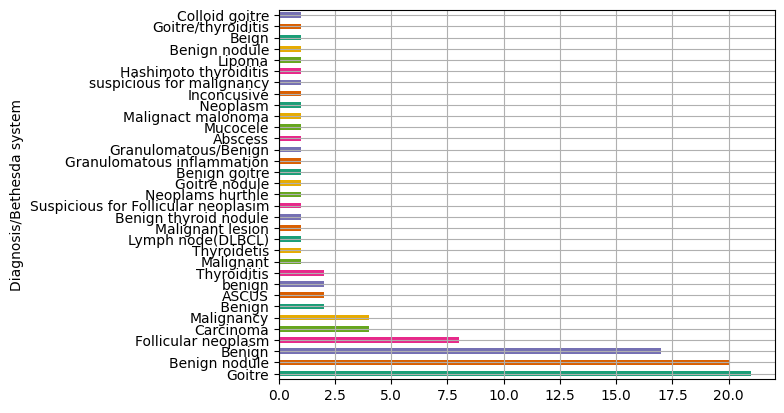

In [11]:
summary_file['Diagnosis/Bethesda system'].value_counts().plot(kind='barh',color=sns.palettes.mpl_palette('Dark2'), grid=True)

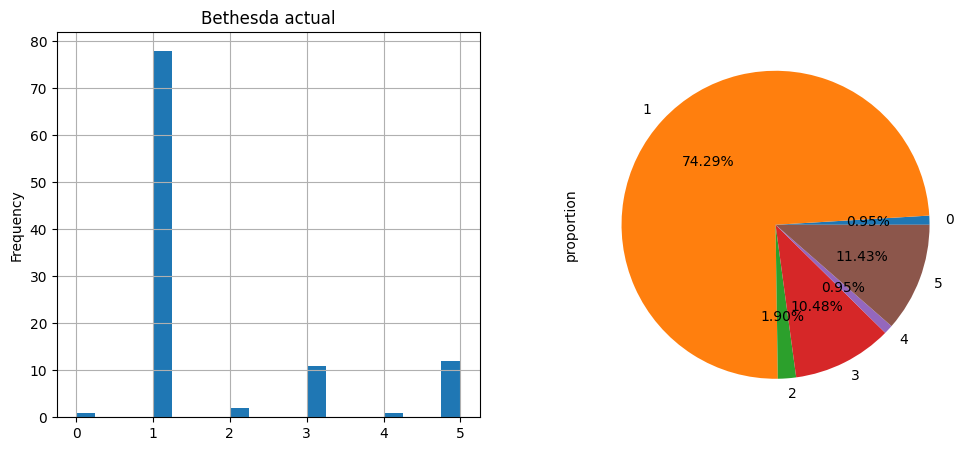

In [12]:
fig, axs = plt.subplots(1,2,figsize=(12,5))
summary_file['Bethesda actual'].plot(kind='hist', bins=20, title='Bethesda actual',ax=axs[0], grid=True)
summary_file['Bethesda actual'].value_counts(dropna=False, normalize=True).fillna('NA').sort_index().plot(kind='pie', autopct='%.2f%%', ax=axs[1])
plt.gca().spines[['top', 'right',]].set_visible(False)

In [13]:
summary_file['Bethesda actual'].value_counts(dropna=False).sort_index()

Bethesda actual
0     1
1    78
2     2
3    11
4     1
5    12
Name: count, dtype: int64

In [14]:
def reload_or_create_classification_summary():
    filename = 'TAN_THYROID_classification_summary.csv'
    filepath = tz_fp / filename
    if not filepath.exists():
        print('Create new file')
        df = []
        for i, r in summary_file.iterrows():
            id, label = r['Scan ID'], r['Bethesda actual']
            id_fp = tz_fp / id
            img_files = list(id_fp.iterdir())
            img_files = [i for i in img_files if (i.name.endswith('.jpg')) and (i.is_file())]
            for i in img_files:
                df.append((str(i), label))
        df = pd.DataFrame(data=df, columns=['img_path', 'label'])
        df['dataset'] = np.random.choice(['train','val','test'],p=[0.6,0.2,0.2], size=len(df))
        df.to_csv(filepath)
    else:
        print('Reload summary file')
        df = pd.read_csv(filepath, index_col=0)
    return df


In [15]:
clf_summary = reload_or_create_classification_summary()

Reload summary file


<Axes: ylabel='count'>

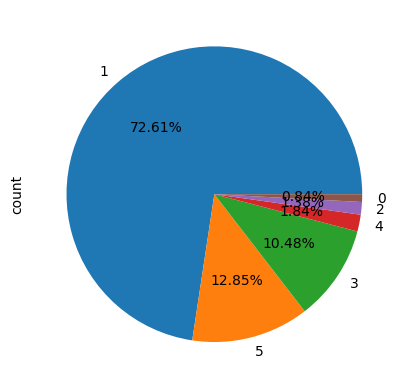

In [16]:
clf_summary['label'].value_counts().plot(kind='pie', autopct='%.2f%%')

In [17]:
clf_summary.groupby('label')['dataset'].value_counts(normalize=False).to_frame('count').reset_index().pivot(index='dataset', columns='label', values='count')

label,0,1,2,3,4,5
dataset,,,,,,
test,1,196,1,25,2,39
train,8,560,13,83,12,109
val,2,193,4,29,10,20


In [18]:
clf_summary['dataset'].value_counts(normalize=True)

dataset
train    0.600612
test     0.201989
val      0.197399
Name: proportion, dtype: float64

In [19]:
clf_summary.head()

,img_path,label,dataset
0,data/Tanzania-Data/TAN001/IMG_20220623_140029.jpg,5,train
1,data/Tanzania-Data/TAN001/IMG_20220623_141314.jpg,5,train
2,data/Tanzania-Data/TAN001/IMG_20220623_134915.jpg,5,train
3,data/Tanzania-Data/TAN001/IMG_20220623_134910.jpg,5,val
4,data/Tanzania-Data/TAN001/IMG_20220623_141335.jpg,5,train


In [20]:
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [21]:
batch_size=8

In [22]:
# prompt: i need pytorch dataset that read from dataframe

class ThyroidDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe['img_path'][idx]
        label = self.dataframe['label'][idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image_path, image, label


In [23]:
test_df = clf_summary[clf_summary['dataset']=='test'].reset_index(drop=True)

In [24]:
test_df['Scan ID'] = test_df.img_path.apply(lambda x: x.split('/')[-2])
test_df['Image ID'] = test_df.img_path.apply(lambda x: '/'.join(x.split('/')[-2:]))

In [25]:
testset = ThyroidDataset(test_df, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=8)

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Load Model

In [28]:
# prompt: train this trainloader using efficient-net model. this is classification problem
model = EfficientNet.from_pretrained('efficientnet-b0')
model._fc = nn.Linear(1280, test_df['label'].nunique())
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3, verbose=True)

# model.load_state_dict(torch.load('../model/TAN_6c/efficientnet-b0-classification.pt', map_location=device))

Loaded pretrained weights for efficientnet-b0


# Run Test

In [29]:
# Test
model.eval()
test_loss = 0.0
test_acc = 0.0
test_f1 = 0.0
test_auc = 0.0
for batch_idx, (filepath, data, target) in enumerate(tqdm(testloader)):
    data, target = data.to(device), target.to(device)
    target = target.clamp(min=0, max=5)
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()
    test_acc += accuracy_score(output.cpu().argmax(dim=1), target.cpu())
    # test_f1 += f1_score(output.argmax(dim=1), target)
    # test_auc += roc_auc_score(target, output[:, 1])
test_loss /= len(testloader)
test_acc /= len(testloader)
test_f1 /= len(testloader)
test_auc /= len(testloader)

print('Test Loss: {:.4f} \tTest Acc: {:.4f}'.format(test_loss, test_acc))


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]


FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/tmp/ipykernel_23176/336583939.py", line 14, in __getitem__
    image = Image.open(image_path)
            ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/PIL/Image.py", line 3247, in open
    fp = builtins.open(filename, "rb")
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: 'data/Tanzania-Data/TAN001/IMG_20220623_140415.jpg'


In [26]:
test_loss, test_acc

(0.5415647090836004, 0.8257575757575758)

In [27]:
def plot_images(filepaths, images, labels, predictions):
  """Plot a batch of images, their labels, and their predictions."""
  fig, axs = plt.subplots(2, 4, figsize=(20, 7))
  for i in range(4):
    img = images[i]
    img = img.cpu().permute(1, 2, 0)
    img = np.clip(img, 0, 1)
    origin_img = Image.open(filepaths[i])
    axs[0, i].imshow(origin_img)
    axs[0, i].set_title(f'Label: {labels[i]}')
    axs[1, i].imshow(img)
    axs[1, i].set_title(f'Pred: {predictions[i]}')
  plt.show()
  print('===================================================================================================================================================')
  print('===================================================================================================================================================')
  print('===================================================================================================================================================')

# Evaluation & Display

  0%|                                                                                            | 0/33 [00:00<?, ?it/s]

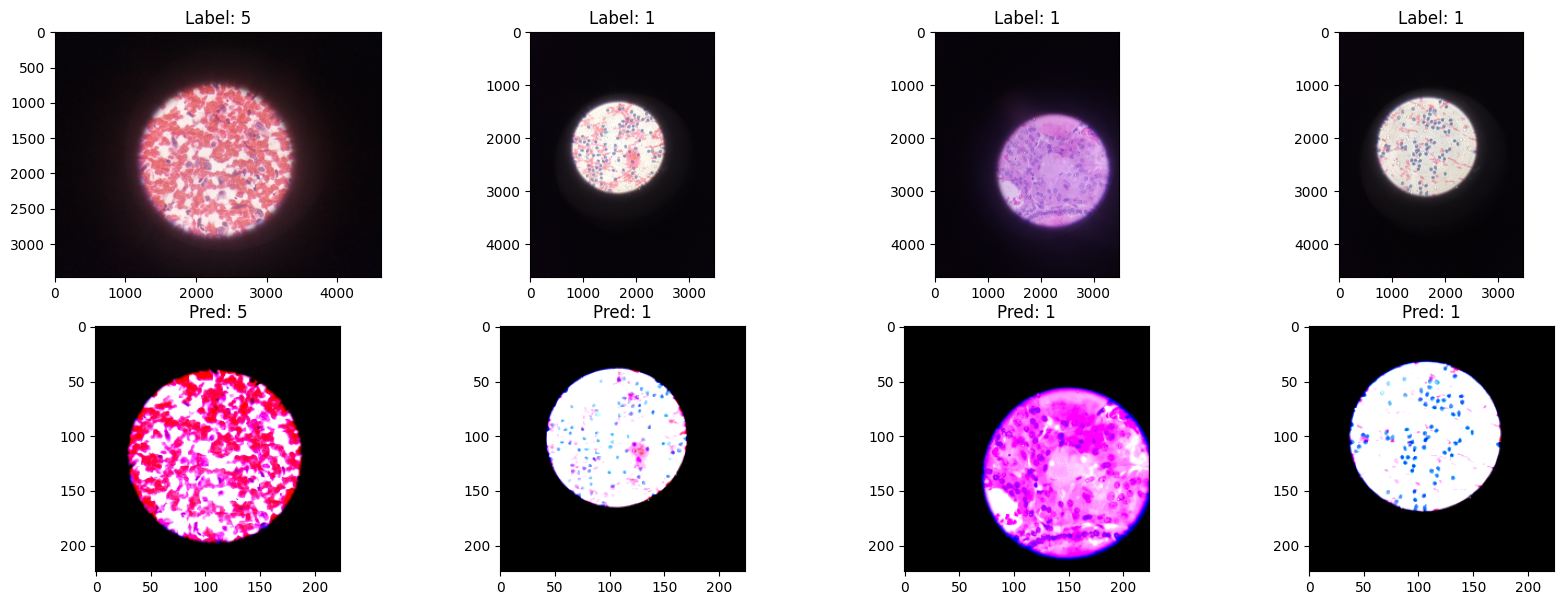

  3%|██▌                                                                                 | 1/33 [00:06<03:13,  6.05s/it]

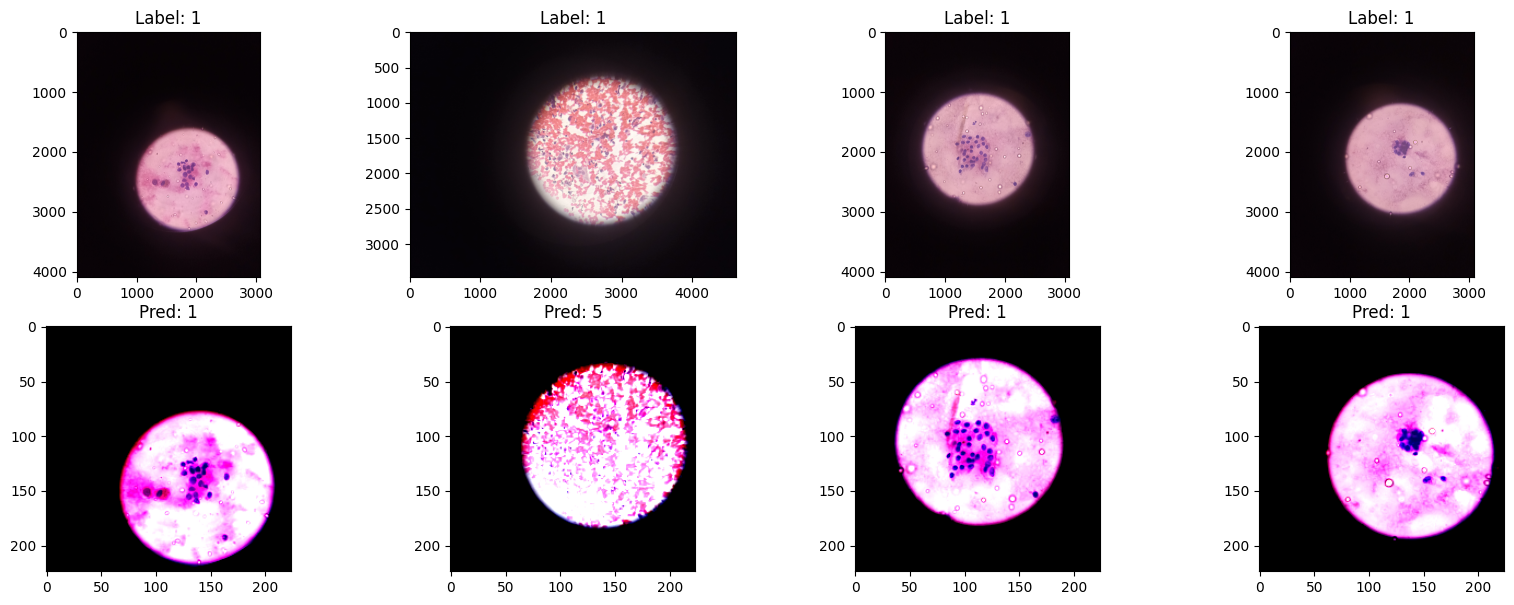

  6%|█████                                                                               | 2/33 [00:10<02:34,  4.98s/it]

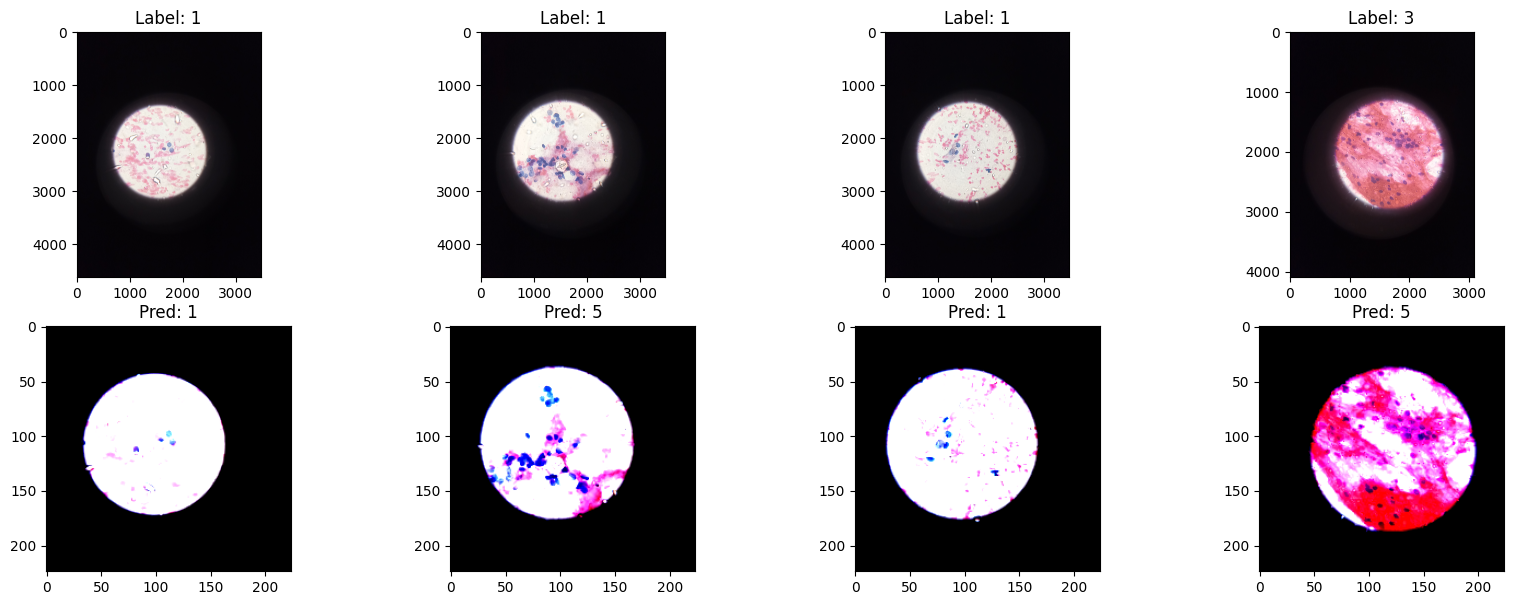

  9%|███████▋                                                                            | 3/33 [00:14<02:18,  4.61s/it]

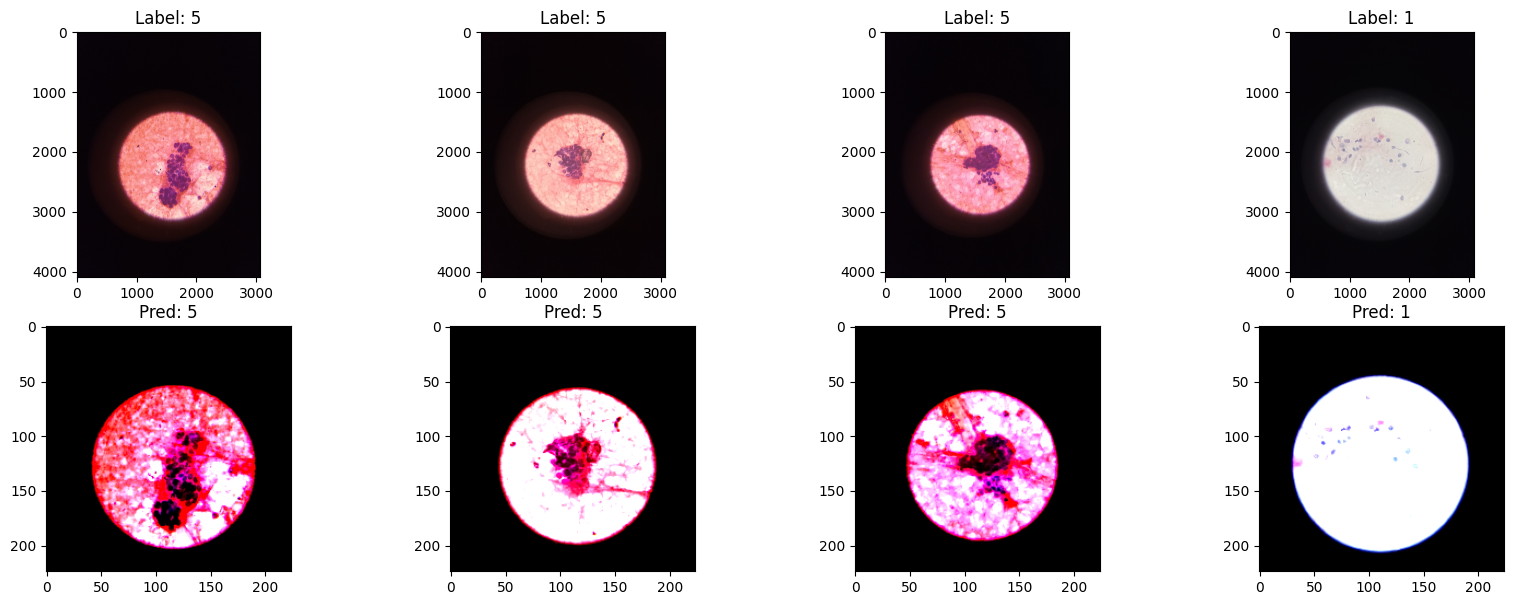

 12%|██████████▏                                                                         | 4/33 [00:18<02:04,  4.30s/it]

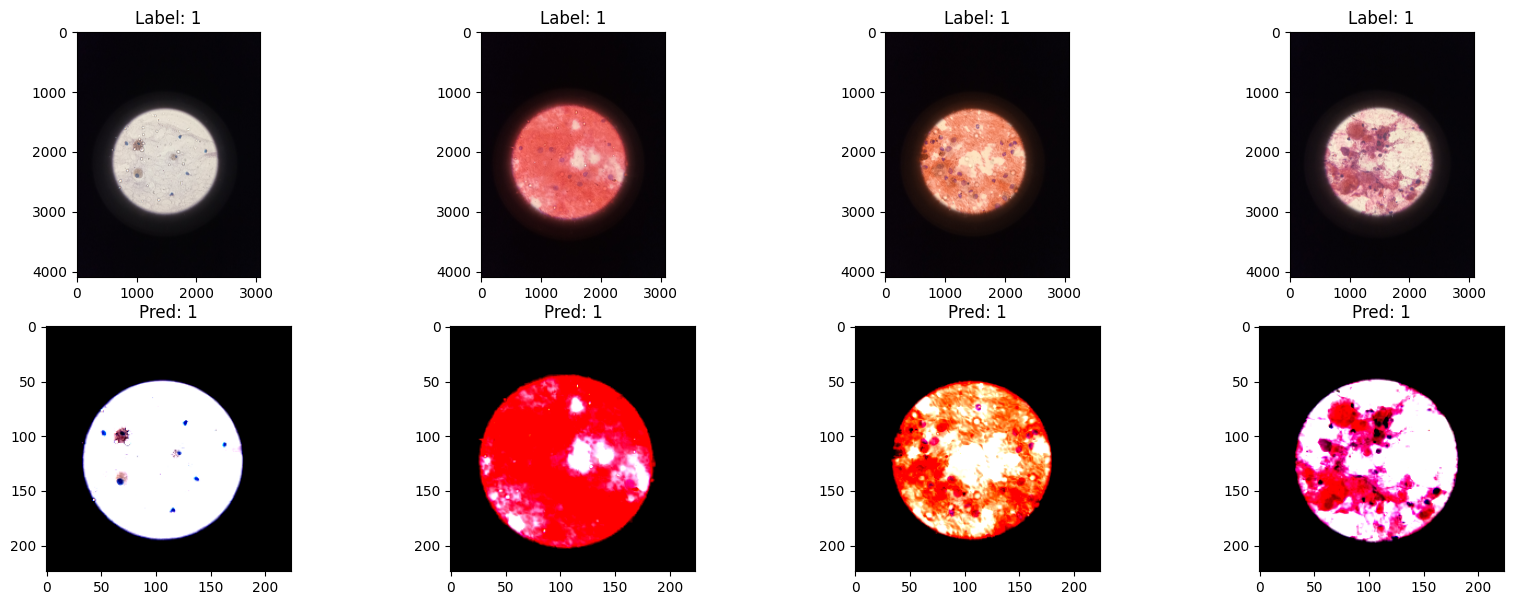

 39%|████████████████████████████████▋                                                  | 13/33 [00:22<00:16,  1.23it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 33/33 [00:23<00:00,  1.39it/s]


In [28]:
# Get a batch of images from the test set.
model.eval()
all_filepaths, all_labels, all_predictions = [], [], []
for batch_idx, (filepaths, images, labels) in enumerate(tqdm(testloader)):
    labels = labels.clamp(min=0, max=5)
    # Make predictions on the images.
    predictions = model(images.to(device)).argmax(dim=1)
    # Increase 1
    # predictions = predictions + 1
    # Plot the images, their labels, and their predictions.
    all_filepaths.extend(filepaths)
    all_labels.extend(labels)
    all_predictions.extend(predictions)
    if batch_idx < 5:
        plot_images(filepaths, images, labels, predictions)

In [29]:
from sklearn import metrics

In [30]:
all_labels = [i.cpu() for i in all_labels]

In [31]:
all_predictions = [i.cpu() for i in all_predictions]

In [32]:
np.unique(all_labels), np.unique(all_predictions)

(array([0, 1, 2, 3, 4, 5]), array([1, 2, 3, 4, 5]))

In [33]:
print(metrics.classification_report(all_labels, all_predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.90      0.89      0.89       196
           2       0.17      1.00      0.29         1
           3       0.81      0.52      0.63        25
           4       1.00      0.50      0.67         2
           5       0.62      0.74      0.67        39

    accuracy                           0.83       264
   macro avg       0.58      0.61      0.53       264
weighted avg       0.84      0.83      0.83       264



/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [34]:
metrics.accuracy_score(all_labels, all_predictions)

0.8257575757575758

In [35]:
def plot_confusion_matrix(labels, pred_labels, classes):
    fig = plt.figure(figsize = (7, 7));
    ax = fig.add_subplot(1, 1, 1);
    cm = metrics.confusion_matrix(labels, pred_labels);
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    fig.delaxes(fig.axes[1]) #delete colorbar
    plt.xticks(rotation = 90)
    plt.xlabel('Predicted Label', fontsize = 10)
    plt.ylabel('True Label', fontsize = 10)

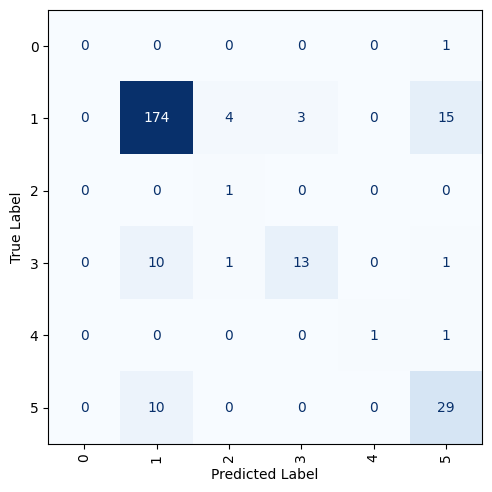

In [36]:
plot_confusion_matrix(all_labels, all_predictions, np.unique(all_labels))

# Predict Patient

In [37]:
test_df['Scan ID'] = test_df.img_path.apply(lambda x: x.split('/')[-2])
test_df['Image ID'] = test_df.img_path.apply(lambda x: '/'.join(x.split('/')[-2:]))

In [38]:
# prompt: i need inference code from a random image
df = []
model.eval()
with torch.no_grad():
    for i, r in test_df.iterrows():
        img_path = r['img_path']
        label = r['label']
        image = Image.open(img_path)

        image = test_transform(image)
        image = image.unsqueeze(0)
        image = image.to(device)
        output = model(image)
        output = output.argmax(dim=1).cpu().numpy()
        output = output[0]
        df.append((img_path, label, output))
        # print(f'Predicted label: {output} - True: {label}')

In [39]:
clf_summary['Scan ID'] = clf_summary.img_path.apply(lambda x: x.split('/')[-2])
clf_summary['Image ID'] = clf_summary.img_path.apply(lambda x: '/'.join(x.split('/')[-2:]))

In [40]:
# check if Scan ID has single label only
(clf_summary.groupby('Scan ID')['label'].nunique().to_frame() - 1).sum()

label    0
dtype: int64

In [41]:
result_df = pd.DataFrame(data=df, columns=['img_path', 'label', 'prediction'])

In [42]:
result_df['Scan ID'] = result_df.img_path.apply(lambda x: x.split('/')[-2])
result_df['Image ID'] = result_df.img_path.apply(lambda x: '/'.join(x.split('/')[-2:]))

In [43]:
tmp = result_df.groupby('Scan ID')['prediction'].agg(lambda x:pd.Series.mode(x)[0]).to_frame()
tmp1 = result_df.groupby('Scan ID')['label'].agg(lambda x:pd.Series.mode(x)[0]).to_frame()
tmp2 = tmp.merge(tmp1, how='inner', right_index=True, left_index=True)
tmp2

,prediction,label
Scan ID,,
TAN001,5,5
TAN002,1,1
TAN003,1,1
TAN004,1,1
TAN005,1,1
...,...,...
TAN100,3,3
TAN101,5,5
TAN102,1,1


In [44]:
y_true = tmp2['label'].tolist()
y_pred = tmp2['prediction'].tolist()

In [45]:
accuracy_score(y_true, y_pred)

0.8695652173913043

In [46]:
clf_summary

,img_path,label,dataset,Scan ID,Image ID
0,data/Tanzania-Data/TAN001/IMG_20220623_140029.jpg,5,train,TAN001,TAN001/IMG_20220623_140029.jpg
1,data/Tanzania-Data/TAN001/IMG_20220623_141314.jpg,5,train,TAN001,TAN001/IMG_20220623_141314.jpg
2,data/Tanzania-Data/TAN001/IMG_20220623_134915.jpg,5,train,TAN001,TAN001/IMG_20220623_134915.jpg
3,data/Tanzania-Data/TAN001/IMG_20220623_134910.jpg,5,val,TAN001,TAN001/IMG_20220623_134910.jpg
4,data/Tanzania-Data/TAN001/IMG_20220623_141335.jpg,5,train,TAN001,TAN001/IMG_20220623_141335.jpg
...,...,...,...,...,...
1302,data/Tanzania-Data/TAN105/IMG_230331130211248.jpg,3,test,TAN105,TAN105/IMG_230331130211248.jpg
1303,data/Tanzania-Data/TAN105/IMG_230331130408736.jpg,3,test,TAN105,TAN105/IMG_230331130408736.jpg
1304,data/Tanzania-Data/TAN105/IMG_230331130526195.jpg,3,train,TAN105,TAN105/IMG_230331130526195.jpg
1305,data/Tanzania-Data/TAN105/IMG_230331130615209.jpg,3,train,TAN105,TAN105/IMG_230331130615209.jpg


In [47]:
print(metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.89      0.97      0.93        66
           2       1.00      1.00      1.00         1
           3       0.86      0.55      0.67        11
           4       1.00      1.00      1.00         1
           5       0.73      0.67      0.70        12

    accuracy                           0.87        92
   macro avg       0.75      0.70      0.71        92
weighted avg       0.86      0.87      0.86        92



/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

# Serving per patient

In [48]:
def predict_patient_id(patient_id):
    df = clf_summary[clf_summary['Scan ID']==patient_id]
    imgs = df['img_path']
    num_imgs = len(imgs)
    label = df['label'].unique()
    datasets = df['dataset'].unique()
    model.eval()
    fig, axs = plt.subplots(3, 5, figsize=(20, 12))
    pred = []
    with torch.no_grad():
        for i, img in enumerate(imgs):
            x = i // 5
            y = i % 5
            if x > 2:
                break
            image = Image.open(img)
            img = image.copy()
            image = test_transform(image)
            image = image.unsqueeze(0)
            image = image.to(device)
            output = model(image)
            output = output.argmax(dim=1).cpu().numpy()[0]
            pred.append(output)
            axs[x, y].imshow(img)
            axs[x, y].set_title(f'Label: {output}')
    major_voting = scipy.stats.mode(pred)
    print(f'{patient_id} - Num_imgs: {num_imgs}, dataset: {datasets}')
    print(f'{patient_id} - Label: {label}, Pred: {major_voting}')
    print(f'{label == major_voting[0]}')
    plt.show()

TAN105 - Num_imgs: 12, dataset: ['train' 'val' 'test']
TAN105 - Label: [3], Pred: ModeResult(mode=1, count=12)
[False]


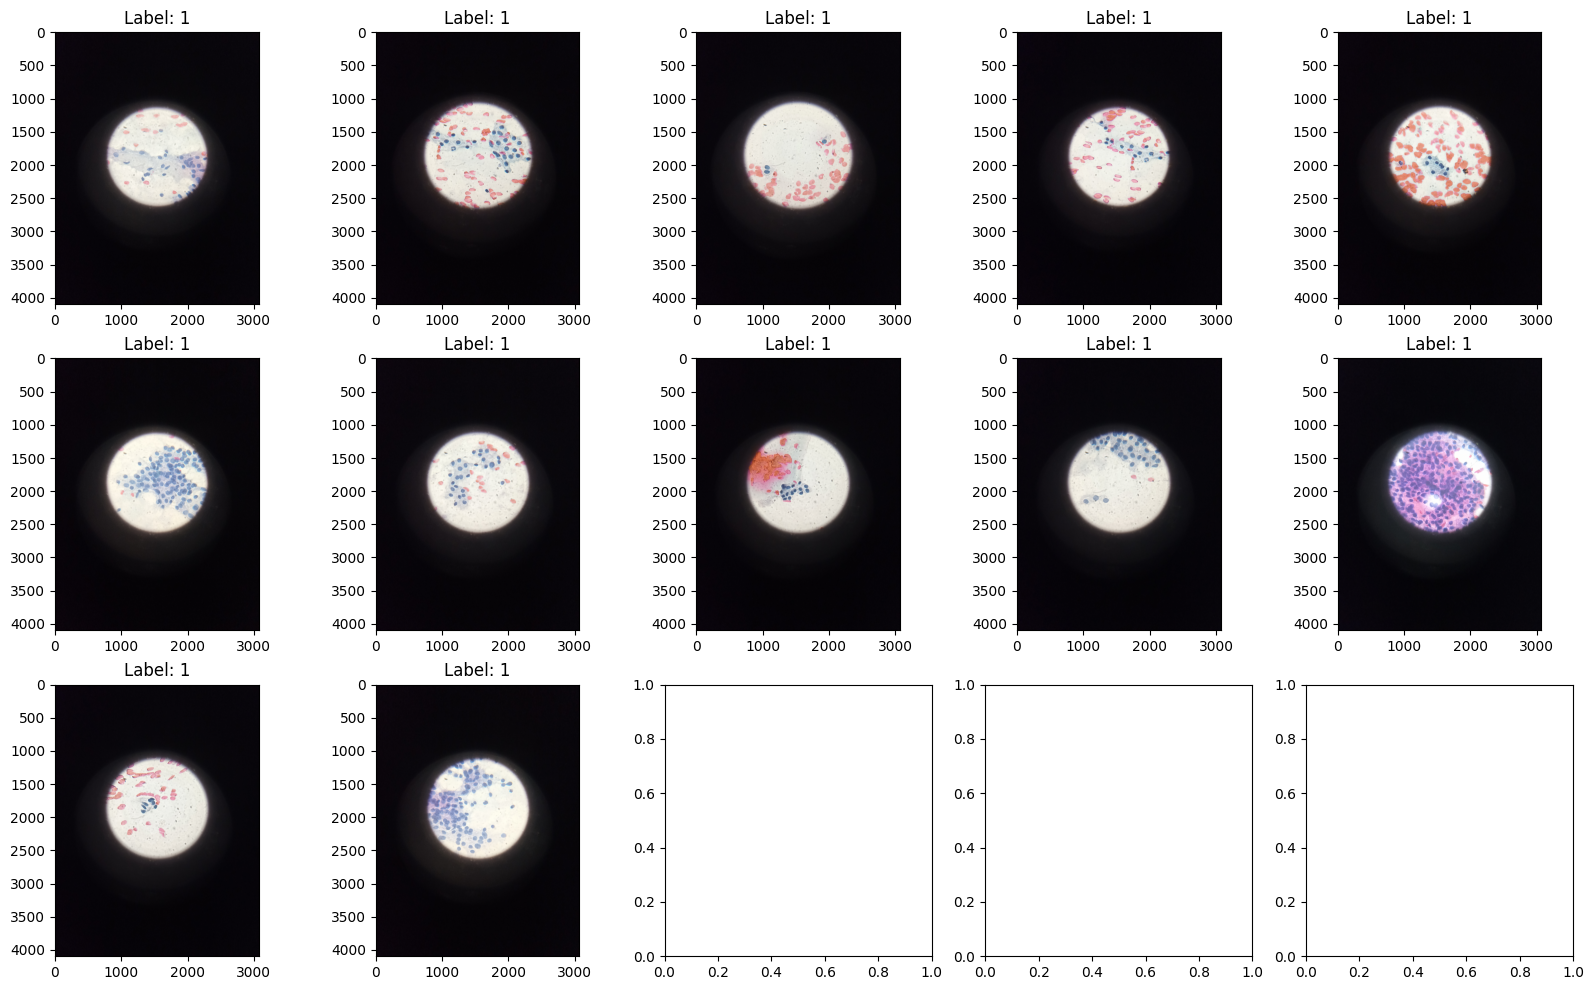

In [49]:
predict_patient_id('TAN105')

# Grad-CAM

In [50]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

In [51]:
device2 = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device2

device(type='cuda', index=1)

In [52]:
image = Image.open(df[0][0])

In [53]:
rgb_img = image.copy()

In [54]:
gradcam_tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

In [55]:
img = image.copy()
img = gradcam_tf(img)

In [56]:
img = img.unsqueeze(0)
img = img.to(device)

In [57]:
# test_transform = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

In [58]:
rgb_img = np.array(rgb_img) / 255

In [59]:
model.eval()

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [60]:
# model = resnet50(pretrained=True)
# target_layers = [model.layer4[-1]]
target_layers = [model._bn1]
input_tensor = img # Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!
# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

targets = [ClassifierOutputTarget(0)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# You can also get the model outputs without having to re-inference
model_outputs = cam.outputs

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.44 GiB. GPU 0 has a total capacty of 7.79 GiB of which 528.50 MiB is free. Process 1656 has 112.68 MiB memory in use. Including non-PyTorch memory, this process has 7.15 GiB memory in use. Of the allocated memory 6.35 GiB is allocated by PyTorch, and 675.71 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
vars(model).keys()